In [1]:
import sys
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install --user --upgrade tensorflow
# !{sys.executable} -m pip install fer

In [1]:
from fer import FER
import matplotlib.pyplot as plt
import cv2

DATA_PATH = "../img-data/"

C:\Users\Stefa\.conda\envs\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Stefa\.conda\envs\python36\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\Stefa\.conda\envs\python36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


Instructions for updating:
non-resource variables are not supported in the long term


C:\Users\Stefa\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Processing video ../img-data/s01_trial01.avi with FPS: 50.0 at Sample Rate: 2 Hz
{0.0: {'angry': 0.02, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.03, 'sad': 0.24, 'surprise': 0.0, 'neutral': 0.69}, 0.5: {'angry': 0.03, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.01, 'sad': 0.25, 'surprise': 0.0, 'neutral': 0.69}, 1.0: {'angry': 0.09, 'disgust': 0.0, 'fear': 0.03, 'happy': 0.07, 'sad': 0.37, 'surprise': 0.0, 'neutral': 0.44}, 1.5: {'angry': 0.06, 'disgust': 0.0, 'fear': 0.03, 'happy': 0.03, 'sad': 0.45, 'surprise': 0.0, 'neutral': 0.44}, 2.0: {'angry': 0.04, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.06, 'sad': 0.34, 'surprise': 0.0, 'neutral': 0.54}, 2.5: {'angry': 0.03, 'disgust': 0.0, 'fear': 0.02, 'happy': 0.05, 'sad': 0.18, 'surprise': 0.0, 'neutral': 0.72}, 3.0: {'angry': 0.03, 'disgust': 0.0, 'fear': 0.02, 'happy': 0.03, 'sad': 0.24, 'surprise': 0.0, 'neutral': 0.68}, 3.5: {'angry': 0.04, 'disgust': 0.0, 'fear': 0.02, 'happy': 0.05, 'sad': 0.27, 'surprise': 0.0, 'neutral': 0.62}, 4.0: {

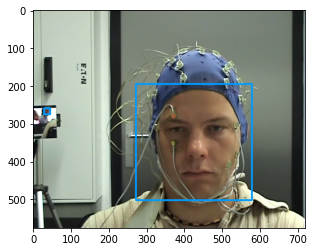

In [2]:
def read_img(img_path):
    return plt.imread(DATA_PATH + img_path)

# def get_area(box):
#     x1, y1 = box[0]
#     x2, y2 = box[2]
#     return (x2 - x1) * (y2 - y1)

def detect_still_img(detector, image, visualize=False):
#     img1 = cv2.imread("tiger.jpg", 3)
#     b,g,r = cv2.split(img)           # get b, g, r
#     img = cv2.merge([r,g,b])     # switch it to r, g, b
    faces = detector.detect_emotions(image)
    
    if len(faces) == 0:
        print("ERROR: No faces detected")
        plt.imshow(image)
        return None
    
    if len(faces) > 1:
        print("WARNING: {} faces detected... selecting largest".format(len(faces)))
        sizes = []
        for face in faces:
            box = face['box']
            sizes.append(box[2] * box[3])
            cv2.rectangle(image,(box[0], box[1]), (box[0] + box[2], box[1] + box[3]),(0, 155, 255), 4,)
        
        max_idx = sizes.index(max(sizes))
        plt.imshow(image)
        return faces[max_idx]['emotions']
#         return None
    
    box = faces[0]['box']
    emotions = faces[0]['emotions']
    if visualize:
        cv2.rectangle(image,(box[0], box[1]), (box[0] + box[2], box[1] + box[3]),(0, 155, 255), 4,)
        plt.imshow(image)
    return emotions
    
    
"""
Function takes in a facial detector, video path, and a sample rate (Hz).
It then returns an dictionary of timestamps -> dict of emotions
    
    Example output:
        {
           "0:00.00" : {"angry": 0.1, "happy": 0.5, "otherEmotions":0.4},
           "0:00.50" : {"angry": 0.2, "happy": 0.4, "otherEmotions":0.4}, ...
        }
"""
def detect_emotions_from_video(detector, path, sample_rate=1):
    video = cv2.VideoCapture(path)
    fps = video.get(cv2.CAP_PROP_FPS)
    
    assert fps >= sample_rate, "Error: FPS {} < Sample Rate {}".format(fps, sample_rate)
    
    print("Processing video {} with FPS: {} at Sample Rate: {} Hz".format(path, fps, sample_rate))
    frame_skip = fps / sample_rate
    i = 0
    data = dict()
    while(video.isOpened()):
        ret, frame = video.read()
        if not ret:
            break

        if i % frame_skip == 0:
            R, G, B = cv2.split(frame)
            frame = cv2.merge([B, G, R])
#             print("Showing_img")
#             plt.imshow(frame)
            emotions = detect_still_img(detector, frame)
            if not emotions:
                break
            data[i / fps] = emotions
        i += 1
    print(data)
    video.release()    
    return data
"""
[cvModelName]-[videoPath].json
{
 "metadata": {
  "videoPath": "filename.mp4",
  "cvLabelFrequency": "2Hz",
  "cvModelName": "default",...
 },
 "data": {
   "0:00.00" : {"angry": 0.1, "happy": 0.5, "otherEmotions":0.4},
   "0:00.50" : {"angry": 0.2, "happy": 0.4, "otherEmotions":0.4}, ...
 }
}
"""

detector = FER(mtcnn=True)
data = detect_emotions_from_video(detector, DATA_PATH + "s01_trial01.avi", sample_rate=2)

{'angry': 0.12,
 'disgust': 0.0,
 'fear': 0.08,
 'happy': 0.1,
 'sad': 0.4,
 'surprise': 0.02,
 'neutral': 0.28}

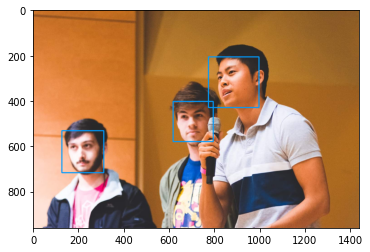

In [3]:
detector = FER(mtcnn=True)
detect_still_img(detector, read_img("3-people.jpg"))

In [4]:
import json

def format_output(video_name, sample_rate, cv_model_name, data, write=False):
    json_dict = dict()
    json_dict["metadata"] = {"videoPath": video_name, "cvLabelFrequency":sample_rate, "cvModelName":cv_model_name}
    json_dict["data"] = data
#     json_object = json.dumps(json_dict, indent = 4)  
#     print(json_object)
    if write:
        with open("../output/{}-{}.json".format(cv_model_name, video_name), "w+") as outfile: 
            json.dump(json_dict, outfile)
format_output("s01_trial01", 2, "default-mtcnn", data, write=True)